<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Estimating the Error Variance

Author(s): Paul Miles | Date Created: August 21, 2018

Included in the [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) package is the ability to estimate the error variance as part of the sampling process.  Furthermore, when using multiple data sets to inform parameter values, you can estimate error variances for each data set separately.  

For more details regarding how to estimate the error variance please refer to:
- Smith, R. C. (2013). Uncertainty quantification: theory, implementation, and applications (Vol. 12). SIAM.
- Marsaglia, G., & Tsang, W. W. (2000). A simple method for generating gamma variables. ACM Transactions on Mathematical Software (TOMS), 26(3), 363-372. [https://doi.org/10.1145/358407.358414](https://doi.org/10.1145/358407.358414)

In [1]:
# import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0rc2


# Define Model and Sum-of-Squares Functions
- Note, the sum-of-squares function is designed to loop through the data sets.

In [2]:
# define model function
def modelfun(xdata, theta):
    m = theta[0]
    b = theta[1]
    nrow, ncol = xdata.shape
    y = np.zeros([nrow, 1])
    y[:,0] = m*xdata.reshape(nrow,) + b
    return y
# define sum-of-squares function
def ssfun(theta, data):
    n = len(data.xdata)
    ss = np.zeros([n])
    for ii in range(n):
        xdata = data.xdata[ii]
        ydata = data.ydata[ii]
        # eval model
        ymodel = modelfun(xdata, theta)
        # calc sos
        ss[ii] = sum((ymodel[:, 0] - ydata[:, 0])**2)
    return ss

# Define Data Set - Plot
We consider two simulated data sets.  Both are linear, but each one has a different level of observation errors.  The first data set has $\varepsilon_i \sim N(0, 0.1)$, whereas the second data set has $\varepsilon_i \sim N(0, 0.5)$.

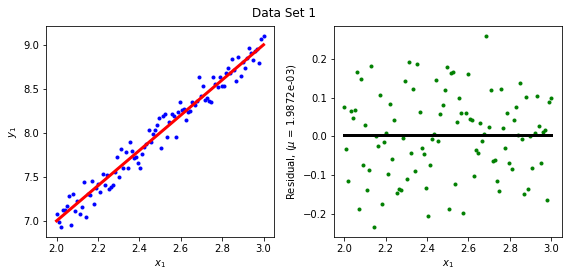

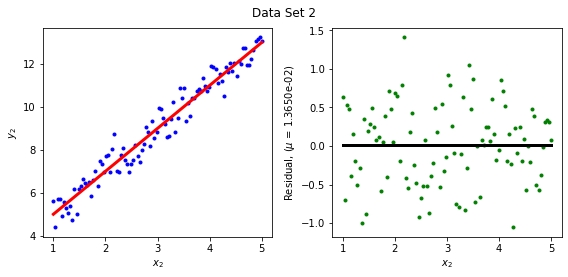

In [4]:
# Add data
nds = 100
m = 2.
b = 3.
x1 = np.linspace(2, 3, num=nds).reshape(nds, 1)
y1 = m*x1 + b + 0.1*np.random.standard_normal(x1.shape)
res1 = y1 - modelfun(x1, [m, b])

x2 = np.linspace(1, 5, num=nds).reshape(nds, 1)
y2 = m*x2 + b + 0.5*np.random.standard_normal(x2.shape)
res2 = y2 - modelfun(x2, [m, b])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(x1, y1, '.b');
plt.plot(x1, modelfun(x1, [m, b]), '-r', linewidth=3);
plt.xlabel('$x_1$'); plt.ylabel('$y_1$');
plt.subplot(1, 2, 2)
plt.plot(x1, res1, '.g');
mr = res1.mean()
plt.plot([x1[0], x1[-1]], [mr, mr], '-k', linewidth=3)
plt.xlabel('$x_1$')
plt.ylabel(str('Residual, ($\\mu$ = {:5.4e})'.format(mr)));
plt.suptitle('Data Set 1')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.figure(figsize=(8, 4))
plt.suptitle('Data Set 2')
plt.subplot(1, 2, 1)
plt.plot(x2, y2, '.b');
plt.plot(x2, modelfun(x2, [m, b]), '-r', linewidth = 3);
plt.xlabel('$x_2$')
plt.ylabel('$y_2$');
plt.subplot(1, 2, 2)
plt.plot(x2, res2, '.g');
mr = res2.mean()
plt.plot([x2[0], x2[-1]], [mr, mr], '-k', linewidth = 3)
plt.xlabel('$x_2$')
plt.ylabel(str('Residual, ($\\mu$ = {:5.4e})'.format(mr)));
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Initialize MCMC Object and Setup Simulation
- We call the `add_data_set` method twice to add each data set to the MCMC data structure.
- The `updatesigma` flag must be turned on in order to include the observation errors in the sampling process.

In [5]:
mcstat = MCMC()
mcstat.data.add_data_set(x1, y1)
mcstat.data.add_data_set(x2, y2)
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e4),
    updatesigma=True,
    method='dram')
mcstat.model_settings.define_model_settings(sos_function=ssfun)
mcstat.parameters.add_model_parameter(name='m', theta0=1.0)
mcstat.parameters.add_model_parameter(name='b', theta0=2.0)

# Run Simulation

In [6]:
# run mcmc
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']
names = results['names']
# define burnin
burnin = int(results['nsimu']/2)
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      1.00 [     -inf,       inf] N( 0.00e+00,      inf)
         b:      2.00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 50000 of 50000 complete in 17.6 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
m         :     2.0152     0.0268     0.0008    33.5006     0.9991
b         :     2.9640     0.0684     0.0022    33.6702     0.9986
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 3.84%
Stage 2: 24.47%
Net    : 28.31% -> 14155/50000
---------------
Chain provided:
Net    : 35.42% -> 8855/25000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


# Plot Parameter Chains, Posteriors, and Observation Standard Deviations

[0.10850098 0.51767411]


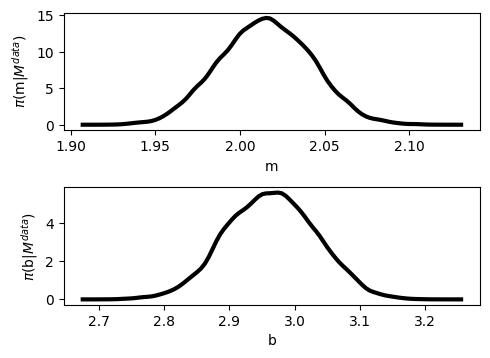

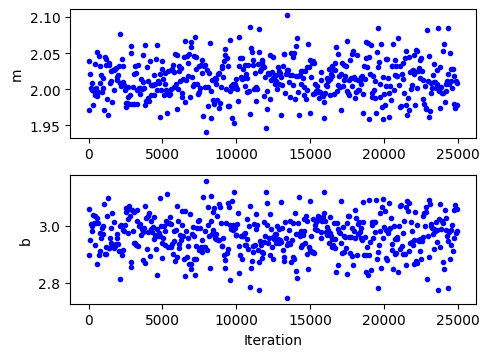

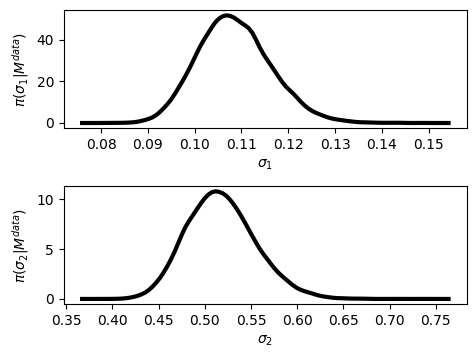

In [7]:
mcpl = mcstat.mcmcplot # initialize plotting methods
mcpl.plot_density_panel(chain[burnin:,:], names);
mcpl.plot_chain_panel(chain[burnin:,:], names);
mcpl.plot_density_panel(np.sqrt(s2chain[burnin:,:]), ['$\\sigma_1$', '$\\sigma_2$']);
print(np.mean(np.sqrt(s2chain[burnin:,:]), axis = 0))

We observe that the estimated observation error standard deviations have mean values around 0.11 and 0.50.  As the data was generated assuming 0.10 and 0.50, this result is in good agreement.

# Plot Prediction/Credible Intervals for Multiple Data Sets

Generating credible/prediction intervals:


Interval generation complete



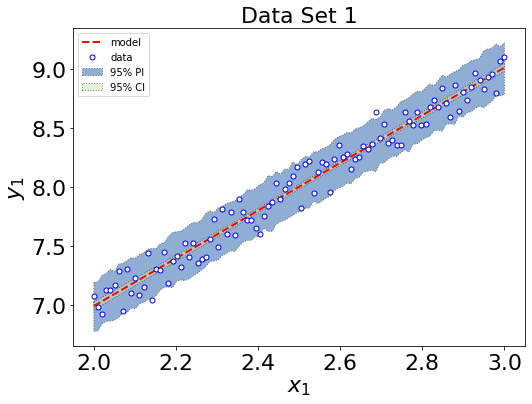

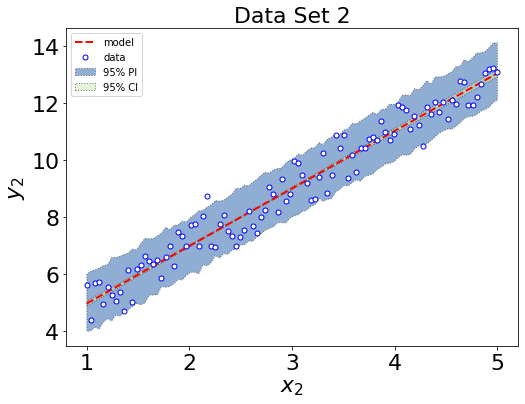

In [8]:
# generate prediction intervals
def pred_modelfun(preddata, theta):
    return modelfun(preddata.xdata[0], theta)
mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=pred_modelfun,
    burnin=burnin)
mcstat.PI.generate_prediction_intervals(calc_pred_int=True)
# plot prediction intervals
data_display = dict(marker='o', color='b', mfc='w')
model_display = dict(color='r', linestyle='--')
figh, axh = mcstat.PI.plot_prediction_intervals(
    adddata=True,
    plot_pred_int=True,
    model_display=model_display,
    data_display=data_display)
for ii, axi in enumerate(axh):
    axi.set_xlabel(str('$x_{}$'.format(ii + 1)), fontsize=22)
    axi.set_ylabel(str('$y_{}$'.format(ii + 1)), fontsize=22)
    axi.set_title(str('Data Set {}'.format(ii + 1)), fontsize=22)
    axi.tick_params(labelsize=22)

# Discussion
We observe the expected behavior as about 95% of the data points are contained within the 95% prediction interval.  The prediction intervals are generated by propagating uncertainty from the parameters and the observation error chain, so this result further supports that our algorithm successfully estimates the observation errors in the data.